In [1]:
import os
import sys
from readrec import *
import matplotlib
from scipy.signal import find_peaks
import numpy as np
import pandas as pd
import re
import glob

from scipy.constants import speed_of_light

c = speed_of_light

sps = 10e6 # 10 Msps

%matplotlib inline
%config InlineBackend.close_figures=True

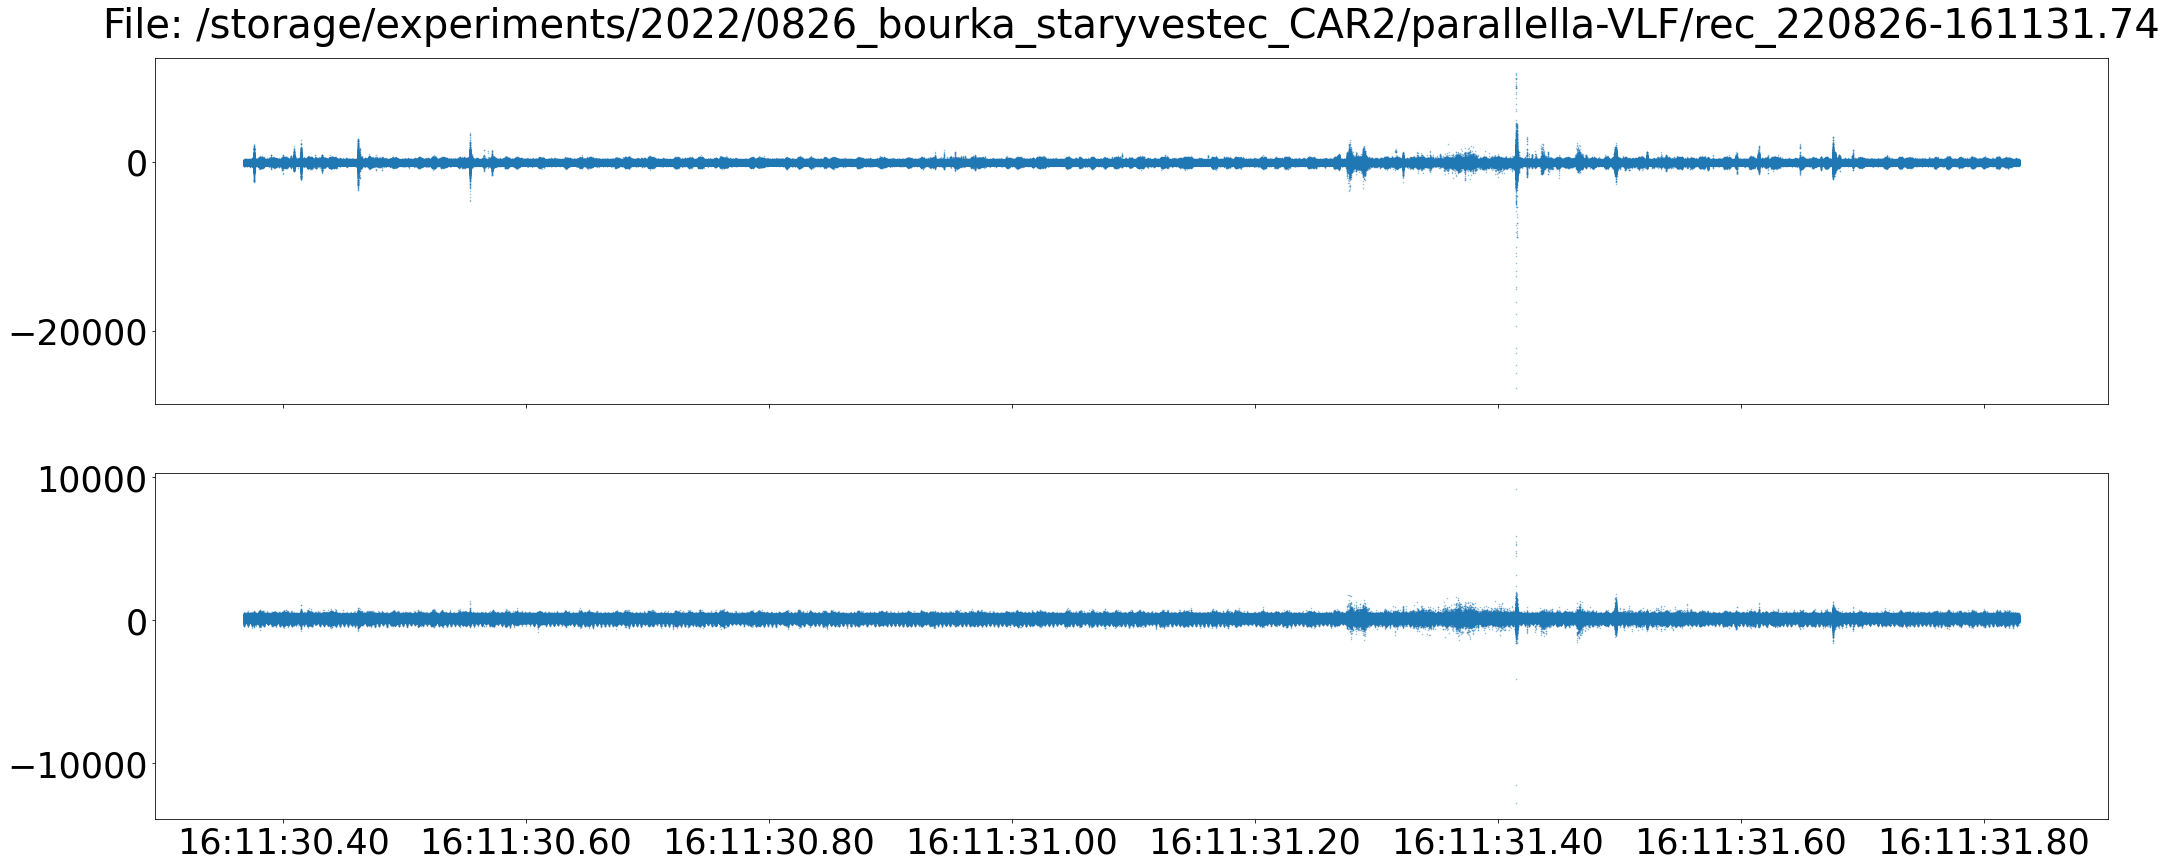

In [2]:

filepath = '/storage/experiments/2022/0826_bourka_staryvestec_CAR2/parallella-VLF/rec_220826-161131.74'

channels = [0,1]
nrows = len(channels) * 1
fig, axs = plt.subplots(figsize=(35, 7 * nrows), nrows=nrows, sharex=True)

mintime = None
data = []

# Load and process data
try:
    with open(filepath, 'rb') as file:
        fn = os.path.basename(filepath)
        h, samples, synclog = loadrec(file)
        t2s, s2t, ticker, formatter = assign_time_axis(fn, h, synclog)

        time = s2t(0)
        mintime = time if mintime is None else min(mintime, time)

        # Add data to the list for later processing
        data.append((filepath, h, samples, synclog, t2s, s2t, ticker, formatter))
except Exception as e:
    print(f"Exception: {e}")

# Render data
ax_idx = 0
for i, (filepath, h, samples, synclog, t2s, s2t, ticker, formatter) in enumerate(data):
    offset = -int(t2s(mintime))

    # Use full path for the file label only once above the first channel
    axs[ax_idx].set_title(f"File: {filepath}", fontsize=40, pad=20)

    a = (h['preTrigger'] - h['preTrigger']) * h['descSpan'] // 16
    b = (h['preTrigger'] + h['postTrigger']) * h['descSpan'] // 16
    for ch in channels:
        signal_samples = samples[a:b, ch]

        axs[ax_idx].xaxis.set_major_locator(ticker)
        axs[ax_idx].xaxis.set_major_formatter(formatter)
        axs[ax_idx].plot(range(a + offset, b + offset), signal_samples, linestyle="", marker=".", alpha=0.5, markersize=1)

        axs[ax_idx].tick_params(axis='x', which='major', labelsize=35)
        axs[ax_idx].tick_params(axis='y', which='major', labelsize=35)

        ax_idx += 1


plt.show()